## 1. Scala's real-world project repository data
<p>With almost 30k commits and a history spanning over ten years, Scala is a mature programming language. It is a general-purpose programming language that has recently become another prominent language for data scientists.</p>
<p>Scala is also an open source project. Open source projects have the advantage that their entire development histories -- who made changes, what was changed, code reviews, etc. -- are publicly available. </p>
<p>We're going to read in, clean up, and visualize the real world project repository of Scala that spans data from a version control system (Git) as well as a project hosting site (GitHub). We will find out who has had the most influence on its development and who are the experts.</p>
<p>The dataset we will use, which has been previously mined and extracted from GitHub, is comprised of three files:</p>
<ol>
<li><code>pulls_2011-2013.csv</code> contains the basic information about the pull requests, and spans from the end of 2011 up to (but not including) 2014.</li>
<li><code>pulls_2014-2018.csv</code> contains identical information, and spans from 2014 up to 2018.</li>
<li><code>pull_files.csv</code> contains the files that were modified by each pull request.</li>
</ol>

In [25]:
# Importing pandas
import pandas as pd

# Loading in the data
pulls_one = pd.read_csv('datasets/pulls_2011-2013.csv')
pulls_two = pd.read_csv('datasets/pulls_2014-2018.csv')
pull_files = pd.read_csv('datasets/pull_files.csv')
print(pulls_one.head())
print(pulls_two.head())
print(pull_files.head())

        pid         user                  date
0  11166973  VladimirNik  2013-12-31T23:10:55Z
1  11161892      Ichoran  2013-12-31T16:55:47Z
2  11153894      Ichoran  2013-12-31T02:41:13Z
3  11151917      rklaehn  2013-12-30T23:45:47Z
4  11131244        qerub  2013-12-29T17:21:01Z
         pid       user                  date
0  163314316     hrhino  2018-01-16T23:29:16Z
1  163061502   joroKr21  2018-01-15T23:44:52Z
2  163057333  mkeskells  2018-01-15T23:05:06Z
3  162985594      lrytz  2018-01-15T15:52:39Z
4  162838837  zuvizudar  2018-01-14T19:16:16Z
         pid                                   file
0  163314316        test/files/pos/t5638/Among.java
1  163314316       test/files/pos/t5638/Usage.scala
2  163314316             test/files/pos/t9291.scala
3  163314316             test/files/run/t8348.check
4  163314316  test/files/run/t8348/TableColumn.java


## 2. Preparing and cleaning the data
<p>First, we will need to combine the data from the two separate pull DataFrames. </p>
<p>Next, the raw data extracted from GitHub contains dates in the ISO8601 format. However, <code>pandas</code> imports them as regular strings. To make our analysis easier, we need to convert the strings into Python's <code>DateTime</code> objects. <code>DateTime</code> objects have the important property that they can be compared and sorted.</p>
<p>The pull request times are all in UTC (also known as Coordinated Universal Time). The commit times, however, are in the local time of the author with time zone information (number of hours difference from UTC). To make comparisons easy, we should convert all times to UTC.</p>

In [34]:
# Append pulls_one to pulls_two
### You can append one DataFrame to another using df1.append(df2, , ignore_index=True). 
### ignore_index ensures that the existing index labels are not used, and the resulting axis 
### will be labeled 0, 1, ..., n-1

pulls = pulls_one.append(pulls_two, ignore_index=True)
print(pulls.head(6))

# Convert the date for the pulls object
### df['column'] = pd.to_datetime(df['column'], utc=True)

pulls['date'] = pd.to_datetime(pulls['date'], utc=True)
print("\n",pulls['date'].head(5))
print('\n')
print(pulls.head())

        pid         user                  date
0  11166973  VladimirNik  2013-12-31T23:10:55Z
1  11161892      Ichoran  2013-12-31T16:55:47Z
2  11153894      Ichoran  2013-12-31T02:41:13Z
3  11151917      rklaehn  2013-12-30T23:45:47Z
4  11131244        qerub  2013-12-29T17:21:01Z
5  11130874      Ichoran  2013-12-29T16:03:55Z

 0   2013-12-31 23:10:55+00:00
1   2013-12-31 16:55:47+00:00
2   2013-12-31 02:41:13+00:00
3   2013-12-30 23:45:47+00:00
4   2013-12-29 17:21:01+00:00
Name: date, dtype: datetime64[ns, UTC]


        pid         user                      date
0  11166973  VladimirNik 2013-12-31 23:10:55+00:00
1  11161892      Ichoran 2013-12-31 16:55:47+00:00
2  11153894      Ichoran 2013-12-31 02:41:13+00:00
3  11151917      rklaehn 2013-12-30 23:45:47+00:00
4  11131244        qerub 2013-12-29 17:21:01+00:00


## 3. Merging the DataFrames
<p>The data extracted comes in two separate files. Merging the two DataFrames will make it easier for us to analyze the data in the future tasks.</p>

In [35]:
# Merge the two DataFrames
### new_df = df_1.merge(df_2, on='column')

data = pulls.merge(pull_files, on="pid")
data.head()

,pid,user,date,file
0,11166973,VladimirNik,2013-12-31 23:10:55+00:00,src/reflect/scala/reflect/api/Printers.scala
1,11166973,VladimirNik,2013-12-31 23:10:55+00:00,src/reflect/scala/reflect/internal/Printers.scala
2,11166973,VladimirNik,2013-12-31 23:10:55+00:00,test/files/run/reify_ann3.check
3,11166973,VladimirNik,2013-12-31 23:10:55+00:00,test/junit/scala/reflect/internal/PrintersTest...
4,11161892,Ichoran,2013-12-31 16:55:47+00:00,src/library/scala/collection/mutable/ArrayOps....


## 4. Is the project still actively maintained?
<p>The activity in an open source project is not very consistent. Some projects might be active for many years after the initial release, while others can slowly taper out into oblivion. Before committing to contributing to a project, it is important to understand the state of the project. Is development going steadily, or is there a drop? Has the project been abandoned altogether?</p>
<p>The data used in this project was collected in January of 2018. We are interested in the evolution of the number of contributions up to that date.</p>
<p>For Scala, we will do this by plotting a chart of the project's activity. We will calculate the number of pull requests submitted each (calendar) month during the project's lifetime. We will then plot these numbers to see the trend of contributions.</p>
<ul>
<li><p>A helpful reminder of how to access various components of a date can be found in <a href="https://campus.datacamp.com/courses/data-manipulation-with-pandas/slicing-and-indexing?ex=12">this exercise of Data Manipulation with pandas</a></p></li>
<li><p>Additionally, recall that you can group by multiple variables by passing a list to <code>groupby()</code>. This video from <a href="https://campus.datacamp.com/courses/data-manipulation-with-pandas/aggregating-data-ad6d4643-0e95-470c-8299-f69cc4c83de8?ex=9">Data Manipulation with pandas</a> should help!</p></li>
</ul>

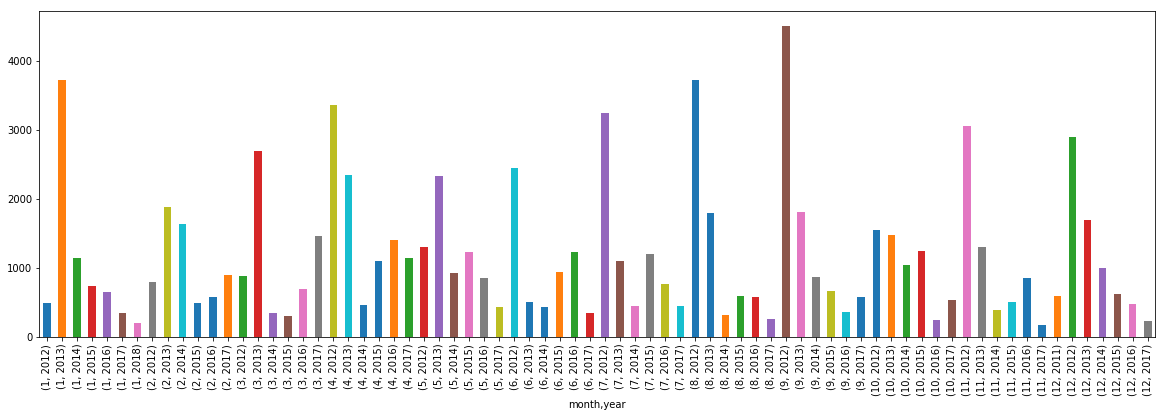

In [30]:
%matplotlib inline

# Create a column that will store the month
data['month'] = data['date'].dt.month

# Create a column that will store the year
data['year'] = data['date'].dt.year

# Group by the month and year and count the pull requests
counts = data.groupby(['month', 'year'])['pid'].count()

# Plot the results
counts.plot(kind='bar', figsize = (20,6))

## 5. Is there camaraderie in the project?
<p>The organizational structure varies from one project to another, and it can influence your success as a contributor. A project that has a very small community might not be the best one to start working on. The small community might indicate a high barrier of entry. This can be caused by several factors, including a community that is reluctant to accept pull requests from "outsiders," that the code base is hard to work with, etc. However, a large community can serve as an indicator that the project is regularly accepting pull requests from new contributors. Such a project would be a good place to start.</p>
<p>In order to evaluate the dynamics of the community, we will plot a histogram of the number of pull requests submitted by each user. A distribution that shows that there are few people that only contribute a small number of pull requests can be used as in indicator that the project is not welcoming of new contributors. </p>

The agg function allows you to specify an aggregating function after you perform a groupby. For example, to select the last date after grouping by file you can run the following code (where max is the aggregating function):

commits.groupby('file').agg({
    'date': 'max'
})

Pandas' DataFrame object has a hist() function that will draw a histogram.


               pid
user              
0xmohit          2
193s             4
2m              20
4.00E+06        22
AlexeyIvanov8    2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f018f2e0048>]],
      dtype=object)

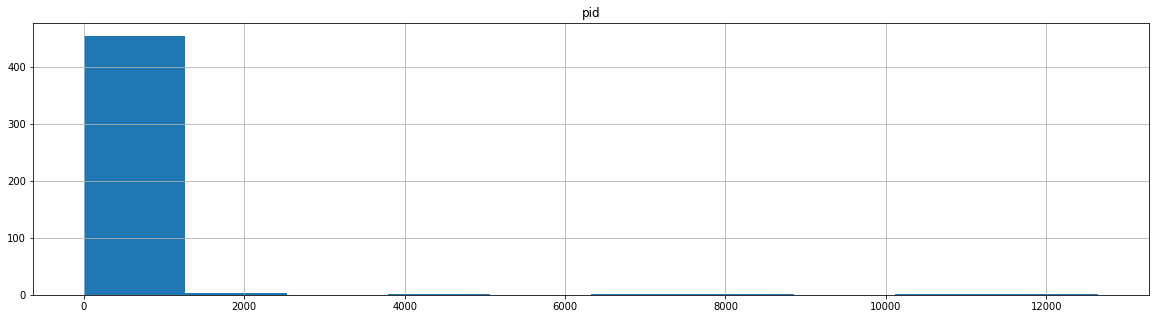

In [42]:
# Required for matplotlib
%matplotlib inline

# Group by the submitter
by_user = data.groupby('user').agg({'pid': 'count'})
print(by_user.head())

# Plot the histogram
by_user.hist(bins=10, figsize=(20,5))

## 6. What files were changed in the last ten pull requests?
<p>Choosing the right place to make a contribution is as important as choosing the project to contribute to. Some parts of the code might be stable, some might be dead. Contributing there might not have the most impact. Therefore it is important to understand the parts of the system that have been recently changed. This allows us to pinpoint the "hot" areas of the code where most of the activity is happening. Focusing on those parts might not the most effective use of our times.</p>

In [43]:
# Identify the last 10 pull requests
last_10 = pulls.nlargest(10, 'date')

# Join the two data sets
joined_pr = last_10.merge(pull_files, on='pid')

# Identify the unique files
files = joined_pr['file'].unique()

# Print the results
print(files)

['test/files/pos/t5638/Among.java' 'test/files/pos/t5638/Usage.scala'
 'test/files/pos/t9291.scala' 'test/files/run/t8348.check'
 'test/files/run/t8348/TableColumn.java'
 'test/files/run/t8348/TableColumnImpl.java'
 'test/files/run/t8348/Test.scala'
 'src/library/scala/concurrent/Lock.scala'
 'src/compiler/scala/tools/nsc/profile/AsyncHelper.scala'
 'src/compiler/scala/tools/nsc/profile/Profiler.scala'
 'src/compiler/scala/tools/nsc/backend/jvm/BCodeHelpers.scala'
 'src/compiler/scala/tools/nsc/symtab/classfile/ClassfileParser.scala'
 'src/reflect/scala/reflect/internal/pickling/ByteCodecs.scala'
 'src/compiler/scala/reflect/reify/phases/Calculate.scala'
 'src/library/scala/Predef.scala' 'test/files/neg/leibniz-liskov.check'
 'test/files/neg/leibniz-liskov.scala'
 'test/files/pos/leibniz-liskov.scala'
 'test/files/pos/leibniz_liskov.scala'
 'src/compiler/scala/tools/nsc/typechecker/Contexts.scala'
 'test/files/pos/parallel-classloader.scala'
 'test/files/pos/t10568/Converter.java' 'tes

## 7. Who made the most pull requests to a given file?
<p>When contributing to a project, we might need some guidance. We might find ourselves needing some information regarding the codebase. It is important direct any questions to the right person. Contributors to open source projects generally have other day jobs, so their time is limited. It is important to address our questions to the right people. One way to identify the right target for our inquiries is by using their contribution history.</p>
<p>We identified <code>src/compiler/scala/reflect/reify/phases/Calculate.scala</code> as being recently changed. We are interested in the top 3 developers who changed that file. Those developers are the ones most likely to have the best understanding of the code.</p>

In [44]:

file = 'src/compiler/scala/reflect/reify/phases/Calculate.scala'

# Select the pull requests that changed the target file
file_pr = pull_files[pull_files["file"] == file]

# Merge the obtained results with the pulls DataFrame
joined_pr = pulls.merge(file_pr, on="pid")

# Find the users of the last 10 most recent pull requests
users_last_10 = set(joined_pr.nlargest(10, 'date')["user"])

# Printing the results
print(users_last_10)

{'zuvizudar', 'starblood', 'xeno-by', 'retronym', 'soc', 'bjornregnell'}


## 8. Who made the last ten pull requests on a given file?
<p>Open source projects suffer from fluctuating membership. This makes the problem of finding the right person more challenging: the person has to be knowledgeable <em>and</em> still be involved in the project. A person that contributed a lot in the past might no longer be available (or willing) to help. To get a better understanding, we need to investigate the more recent history of that particular part of the system. </p>
<p>Like in the previous task, we will look at the history of  <code>src/compiler/scala/reflect/reify/phases/Calculate.scala</code>.</p>

In [45]:
# This is the file we are interested in:
file = 'src/compiler/scala/reflect/reify/phases/Calculate.scala'

# Identify the commits that changed the file
file_pr = data[data["file"] == file]

# Count the number of changes made by each developer
author_counts = file_pr.groupby("user")["pid"].count()

# Print the top 3 developers
print(author_counts.nlargest(3))

user
xeno-by     11
retronym     5
soc          4
Name: pid, dtype: int64


## 9. The pull requests of two special developers
<p>Now that we have identified two potential contacts in the projects, we need to find the person who was most involved in the project in recent times. That person is most likely to answer our questions. For each calendar year, we are interested in understanding the number of pull requests the authors submitted. This will give us a high-level image of their contribution trend to the project.</p>

In [46]:
%matplotlib inline

# The developers we are interested in
authors = ['xeno-by', 'soc']

# Get all the developers' pull requests
by_author = ...

# Count the number of pull requests submitted each year
counts = by_author.groupby([..., ...]).agg({'pid': 'count'}).reset_index()

# Convert the table to a wide format
counts_wide = counts.pivot_table(index='date', columns='user', values='pid', fill_value=0)

# Plot the results
# ... YOUR CODE FOR TASK 9 ...

AttributeError: 'ellipsis' object has no attribute 'groupby'

## 10. Visualizing the contributions of each developer
<p>As mentioned before, it is important to make a distinction between the global expertise and contribution levels and the contribution levels at a more granular level (file, submodule, etc.) In our case, we want to see which of our two developers of interest have the most experience with the code in a given file. We will measure experience by the number of pull requests submitted that affect that file and how recent those pull requests were submitted.</p>

In [0]:
authors = ['xeno-by', 'soc']
file = 'src/compiler/scala/reflect/reify/phases/Calculate.scala'

# Select the pull requests submitted by the authors, from the `data` DataFrame
by_author = ...

# Select the pull requests that affect the file
by_file = ...

# Group and count the number of PRs done by each user each year
grouped = by_file.groupby(['user', by_file['date'].dt.year]).count()['pid'].reset_index()

# Transform the data into a wide format
by_file_wide = ...

# Plot the results
by_file_wide.plot(kind='bar')